In DSP, where the input and output are signals, a filter has one input signal and one output signal:

In [1]:
%%html
<img src="https://pysdr.org/_images/filter.png">

There are four basic types of filters: low-pass, high-pass, band-pass, and band-stop. Each type modifies signals to focus on different ranges of frequencies within them. The graphs below demonstrate how frequencies in signals are filtered for each type.

In [2]:
%%html
<img src="https://pysdr.org/_images/filter_types.png">

Let’s visualize transition width. In the diagram below, the green line represents the ideal response for transitioning between a passband and stopband, which essentially has a transition width of zero. The Red line demonstrates the result of a realistic filter, which has some ripple and a certain transition width.

In [3]:
%%html
<img src="https://pysdr.org/_images/realistic_filter.png">

Simply plotting this array of floats gives us the filter’s impulse response:



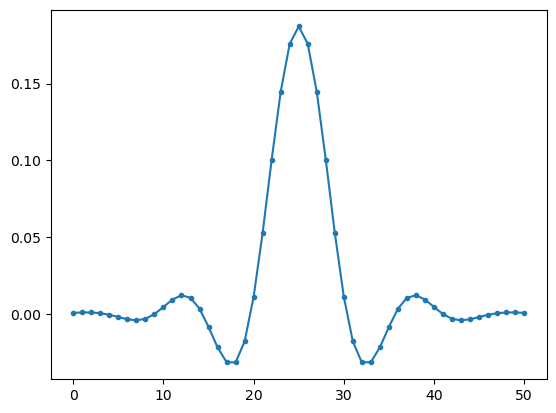

In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

num_taps = 51 # it helps to use an odd number of taps
cut_off = 3000 # Hz
sample_rate = 32000 # Hz

# create our low pass filter
h = signal.firwin(num_taps, cut_off, nyq=sample_rate/2)

# plot the impulse response
plt.plot(h, '.-')
plt.show()

Real vs. Complex Filters
The filter I showed you had real taps, but taps can also be complex. Whether the taps are real or complex doesn’t have to match the signal you put through it, i.e., you can put a complex signal through a filter with real taps and vice versa. When the taps are real, the filter’s frequency response will be symmetrical around DC (0 Hz). Typically we use complex taps when we need asymmetry, which does not happen too often.

In [4]:
%%html
<img src="https://pysdr.org/_images/complex_taps.png">

The plots of the impulse response and frequency response are shown below:

In [5]:
# (h was found using the first code snippet)

# Shift the filter in frequency by multiplying by exp(j*2*pi*f0*t)
f0 = 10e3 # amount we will shift
Ts = 1.0/sample_rate # sample period
t = np.arange(0.0, Ts*len(h), Ts) # time vector. args are (start, stop, step)
exponential = np.exp(2j*np.pi*f0*t) # this is essentially a complex sine wave

h_band_pass = h * exponential # do the shift

# plot impulse response
plt.figure('impulse')
plt.plot(np.real(h_band_pass), '.-')
plt.plot(np.imag(h_band_pass), '.-')
plt.legend(['real', 'imag'], loc=1)

# plot the frequency response
H = np.abs(np.fft.fft(h_band_pass, 1024)) # take the 1024-point FFT and magnitude
H = np.fft.fftshift(H) # make 0 Hz in the center
w = np.linspace(-sample_rate/2, sample_rate/2, len(H)) # x axis
plt.figure('freq')
plt.plot(w, H, '.-')
plt.xlabel('Frequency [Hz]')
plt.show()

NameError: name 'sample_rate' is not defined

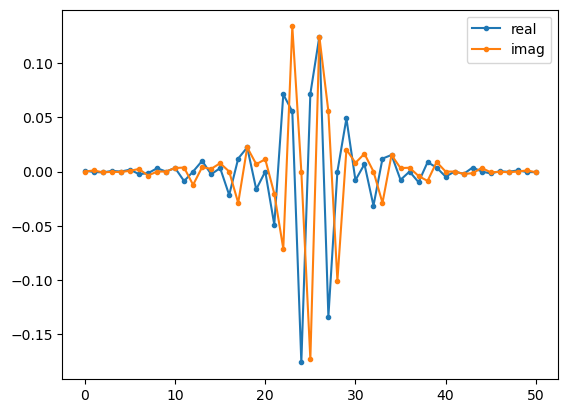

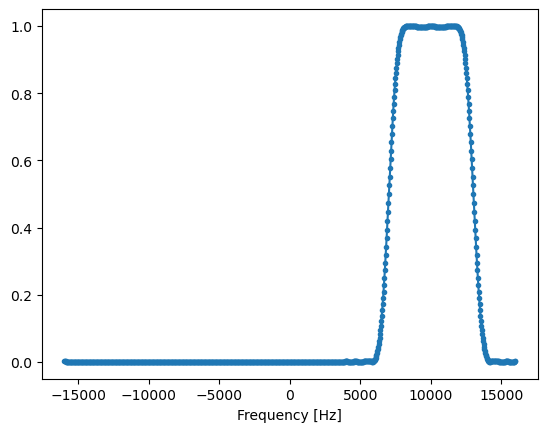

In [3]:
# (h was found using the first code snippet)

# Shift the filter in frequency by multiplying by exp(j*2*pi*f0*t)
f0 = 10e3 # amount we will shift
Ts = 1.0/sample_rate # sample period
t = np.arange(0.0, Ts*len(h), Ts) # time vector. args are (start, stop, step)
exponential = np.exp(2j*np.pi*f0*t) # this is essentially a complex sine wave

h_band_pass = h * exponential # do the shift

# plot impulse response
plt.figure('impulse')
plt.plot(np.real(h_band_pass), '.-')
plt.plot(np.imag(h_band_pass), '.-')
plt.legend(['real', 'imag'], loc=1)

# plot the frequency response
H = np.abs(np.fft.fft(h_band_pass, 1024)) # take the 1024-point FFT and magnitude
H = np.fft.fftshift(H) # make 0 Hz in the center
w = np.linspace(-sample_rate/2, sample_rate/2, len(H)) # x axis
plt.figure('freq')
plt.plot(w, H, '.-')
plt.xlabel('Frequency [Hz]')
plt.show()

Filter Design in Python

You start by creating a vector of your desired frequency response. Let’s design an arbitrarily shaped low-pass filter shown below:

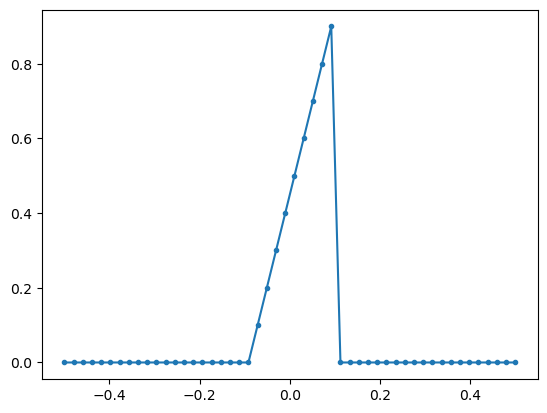

In [4]:
import numpy as np
import matplotlib.pyplot as plt
H = np.hstack((np.zeros(20), np.arange(10)/10, np.zeros(20)))
w = np.linspace(-0.5, 0.5, 50)
plt.plot(w, H, '.-')
plt.show()

always should FFTshift after an FFT and IFFshift after an IFFT

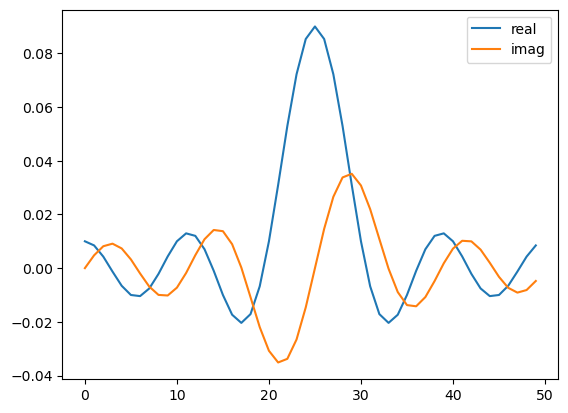

In [8]:
import numpy as np
import matplotlib.pyplot as plt
H = np.hstack((np.zeros(20), np.arange(10)/10, np.zeros(20)))
w = np.linspace(-0.5, 0.5, 50)
h = np.fft.ifftshift(np.fft.ifft(np.fft.ifftshift(H)))
plt.plot(np.real(h))
plt.plot(np.imag(h))
plt.legend(['real','imag'], loc=1)
plt.show()

We will use these taps shown above as our filter. We know that the impulse response is plotting the taps, so what we see above is our impulse response. Let’s take the FFT of our taps to see what the frequency domain actually looks like. We will do a 1,024 point FFT to get a high resolution:

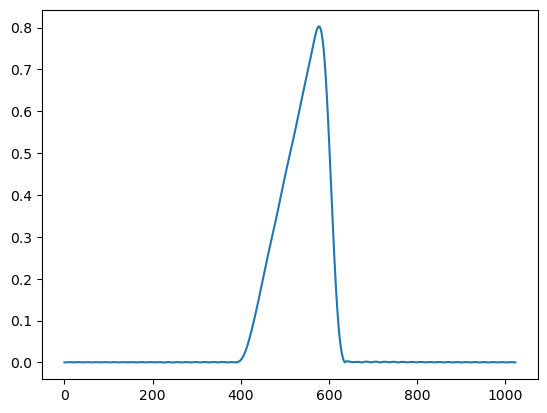

In [12]:
import numpy as np
import matplotlib.pyplot as plt
H = np.hstack((np.zeros(20), np.arange(10)/10, np.zeros(20)))
H_fft = np.fft.fftshift(np.abs(np.fft.fft(h, 1024)))
plt.plot(H_fft)
plt.show()

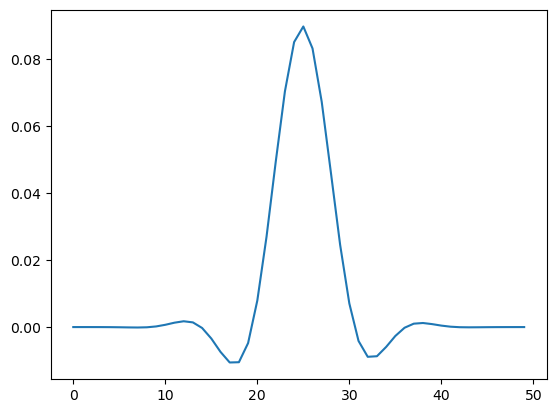

In [14]:
# After creating h using the previous code, create and apply the window
window = np.hamming(len(h))
h = h * window
plt.plot(h)
plt.show()

Intro to Pulse Shaping

We use filters to craft the “shape” of our symbols because the shape in the time domain changes the shape in the frequency domain. The frequency domain informs us how much spectrum/bandwidth our signal will use, and we usually want to minimize it. What is important to understand is that the spectral characteristics (frequency domain) of the baseband symbols do not change when we modulate a carrier; it just shifts the baseband up in frequency while the shape stays the same, which means the amount of bandwidth it uses stays the same. When we use 1 sample per symbol, it’s like transmitting square pulses. In fact BPSK using 1 sample per symbol is just a square wave of random 1’s and -1’s:

In [15]:
%%html
<img src="https://pysdr.org/_images/bpsk.svg">

And as we have learned, square pulses are not efficient because they use an excess amount of spectrum:

In [16]:
%%html
<img src="https://pysdr.org/_images/square-wave.svg">

So what we do is we “pulse shape” these blocky-looking symbols so that they take up less bandwidth in the frequency domain. We “pulse shape” by using a low-pass filter because it discards the higher frequency components of our symbols. Below shows an example of symbols in the time (top) and frequency (bottom) domain, before and after a pulse-shaping filter has been applied:

In [18]:
%%html
<img src="https://pysdr.org/_images/pulse_shaping.png">

In [19]:
%%html
<img src="https://pysdr.org/_images/pulse_shaping_freq.png">

Note how much quicker the signal drops off in frequency. The sidelobes are ~30 dB lower after pulse shaping; that’s 1,000x less! And more importantly, the main lobe is narrower, so less spectrum is used for the same amount of bits per second.

Below demonstrates the time and frequency domain of a raised-cosine filter with different values of \beta, the parameter that defines how steep the roll-off is.

In [20]:
%%html
<img src="https://pysdr.org/_images/pulse_shaping_rolloff.png">

You can see that a lower value of \beta reduces the spectrum used (for the same amount of data). However, if the value is too low then the time domain symbols take longer to decay to zero. Actually when \beta=0 the symbols never fully decay to zero, which means we can’t transmit such symbols in practice. A \beta value around 0.35 is common.